# WASP-6 Spitzer Light Curves

Observations are archived [here](http://sha.ipac.caltech.edu/applications/Spitzer/SHA/#id=SearchByPosition&RequestClass=ServerRequest&DoSearch=true&SearchByPosition.field.radius=0.13888889000000001&UserTargetWorldPt=348.157296;-22.673933;EQ_J2000&TargetPanel.field.targetName=wasp-6&SimpleTargetPanel.field.resolvedBy=nedthensimbad&MoreOptions.field.prodtype=aor,pbcd&shortDesc=Position&isBookmarkAble=true&isDrillDownRoot=true&isSearchResult=true).

In [1]:
%matplotlib inline
import pyfits
import numpy as np
import matplotlib
matplotlib.rcParams['font.size'] = 15
from matplotlib import pyplot as plt
import sys
sys.path.append('../../')
import photPack2
from astropy.time import Time
import emcee

## Read in raw data, organize
rawch1 = np.genfromtxt('wasp6_channel1.txt')
rawch2 = np.genfromtxt('wasp6_channel2.txt')

ch1 = {}
ch2 = {}
for rawdata, output in zip([rawch1, rawch2], [ch1, ch2]):
    for i, key, offset in zip(range(3), ['t', 'f', 'e'], [2450000.0, 0.0, 0.0]):
        output[key] = rawdata[:,i] + offset

for ch in [ch1, ch2]:
    ch['e'] = np.zeros_like(ch['f']) + np.std(ch['f'][int(0.66*len(ch['f'])):])

## Double check that time offset is what I think it is, by subtracting the start time
## of the observations shown on the Spitzer Heritage Archive to the start time of the data:
# print Time('2013-01-21 08:23:00', format='iso', scale='utc').jd - ch1['t'].min() + 0.00195

print np.median(ch1['t']), np.median(ch2['t']), len(ch1['t'])

#plt.plot(ch2['t'], ch2['f'],'.')
#plt.show()

2456313.94851 2456307.23216 1999


In [26]:
# plt.hist(np.diff(ch1['t']*24*60*60),100)
# plt.show()

In [27]:
import sys
sys.path.append('/astro/users/bmmorris/Downloads/Fast_MA')
from ext_func.rsky import rsky
from ext_func.occultquad import occultquad

def get_lc(aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, t):
    '''
    e - eccentricity
    aRs - "a over R-star"
    i - inclination angle in radians
    u1, u2 - quadratic limb-darkening coeffs
    p0 - planet to star radius ratio
    w - argument of periapse
    period - period
    t0 - midtransit (JD)
    eps - minimum eccentricity for Kepler's equation
    t - time array
    '''
    u1 = 2*np.sqrt(q1)*q2
    u2 = np.sqrt(q1)*(1 - 2*q2)
    r_s = 1.0
    npoints = len(t)
    z0 = rsky(e, aRs, i, r_s, w, period, t0, eps, t)   #calculates separation of centers between the planet and the star
    mu_c = occultquad(z0, u1, u2, p0, npoints)   #returns limb darkened model lightcurve
    return F0*mu_c

from scipy import optimize
aOverRs = 1./0.0932 # Jord`an et al 2013
RpOverRs = 0.1404   # Jord`an et al 2013
eccentricity = 0.054
inclination = np.radians(88.47)
q1 = 0.00001
q2 = 0.2
periapse = np.pi/2
period = 3.361006
mineccentricity = 1.0e-7
t0_roughfits = [2456313.94851, 2456307.23216]


paramlimits = [[8.0, 14.0],  #aRs
               [np.radians(85), np.radians(95.0)],
               [np.min(ch1['t']), np.max(ch1['t'])],
               [np.min(ch2['t']), np.max(ch2['t'])],
               [0, 1.0], [0, 1.0], # LD ch1
               [0, 1.0], [0, 1.0], # LD ch2
               [0, 0.3], [0, 0.3], # RpRs Ch1, ch2
               [0.1,10], [0.1,10]] # F0 ch1. ch2
lastp = 0

#meantimediff = np.median(np.diff(times))
#exptime = np.median(exposuredurs)/(60*60*24) # convert to units of days from seconds
exposuredurs = np.zeros(len(ch1['t'])) + 2
def fine_lc(aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, t):
    meantimediff = np.median(np.diff(t))
    new_t = np.linspace(t.min() - 2*meantimediff, t.max() + 2*meantimediff, 5*len(t))
    return new_t, get_lc(aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, new_t)

def binned_lc(aOverRs, inclination, t0_roughfit, q1, q2, RpOverRs, F0, eccentricity, 
              periapse, period, eps, t):
    exptime = np.median(exposuredurs)/(60*60*24) # convert to units of days from seconds

    new_t, finemodel = fine_lc(aOverRs, inclination, t0_roughfit, q1, q2, RpOverRs, 
                               F0, eccentricity, periapse, period, eps, t)
    timebinedges = np.sort(np.concatenate([t - 0.5*exptime, t + 0.5*exptime]))
    d = np.digitize(new_t, timebinedges)
    binned_model = np.array([np.mean(finemodel[d == i]) for i in range(1, 2*len(t), 2)])
    return binned_model

def genmodel(parameters):
    model = np.zeros(len(ch1['t'])+len(ch2['t']))
    aRs, inclination, t0_ch1, t0_ch2, q1_ch1, q2_ch1, q1_ch2, q2_ch2, RpRs_ch1, RpRs_ch2, F0_ch1, F0_ch2 = parameters
    for i, lcparams in enumerate(([aRs, inclination, t0_ch2, q1_ch2, q2_ch2, RpRs_ch2, F0_ch2,
                      eccentricity, periapse, period, mineccentricity, ch2['t']],
                      [aRs, inclination, t0_ch1, q1_ch1, q2_ch1, RpRs_ch1, F0_ch1, 
                      eccentricity, periapse, period, mineccentricity, ch1['t']])):
        #aRs, i, t0, q1, q2, p0, F0, e, w, period, eps, t
        if i == 0:
            model[:len(ch2['t'])] = binned_lc(*lcparams)
        else:
            model[len(ch2['t']):] = binned_lc(*lcparams)
    return model

def lnlike(theta, x, y, yerr):
    model = genmodel(theta)
    return -0.5*np.sum((y-model)**2/yerr**2)
#    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
#    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))
#     inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
#     return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

#return -0.5*(np.sum((y-model)**2/yerr**2))# - np.log(inv_sigma2)))
def lnprior(theta, paramlimits=paramlimits):
    parameters = theta
    # If parameter is locked, limits are set to [0,0]. If parameter is not locked,
    # check that all values for that parameter are within the set limits. If they are,
    # return 0.0, else return -np.inf
    for i, limits in enumerate(paramlimits):
        if not ((limits[0] < parameters[i]) and (parameters[i] < limits[1])):
            return -np.inf
    return 0.0

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

aRs 10.4938658184 0.01
inclination 1.53491066634 0.00174532925199
t0_ch1 2456313.90327 0.00208333333333
t0_ch2 2456307.18061 0.00208333333333
q1_ch1 0.0226834973402 0.1
q2_ch1 0.114540398079 0.1
q1_ch2 0.00800048311684 0.1
q2_ch2 0.204462548157 0.1
RpRs_ch1 0.135897377346 0.005
RpRs_ch2 0.142709436779 0.005
F0_ch1 0.999942281886 0.001
F1_ch2 1.00002951122 0.001


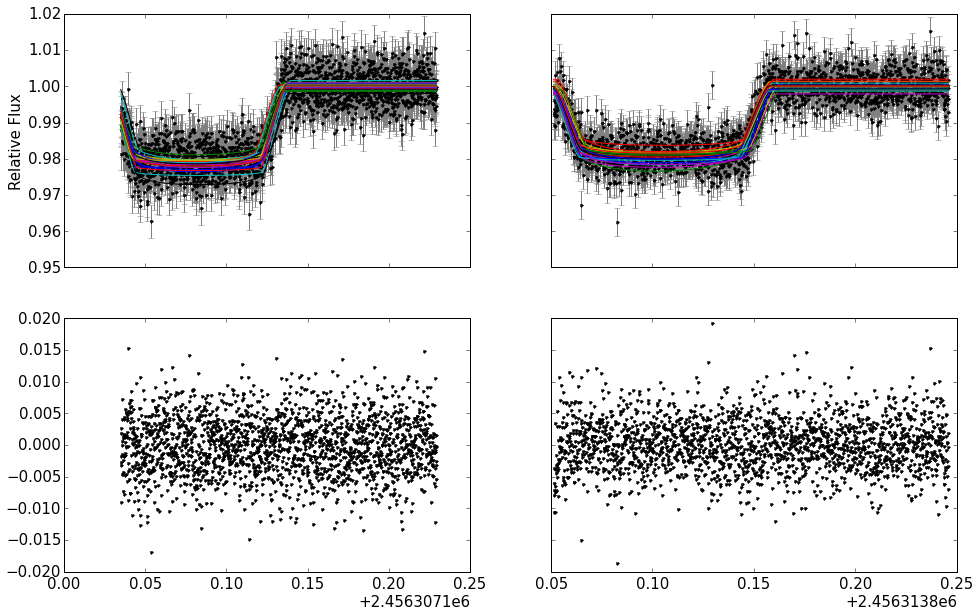

In [28]:
labels = ['aRs', 'inclination', 't0_ch1', 't0_ch2', 'q1_ch1', 'q2_ch1', 
          'q1_ch2', 'q2_ch2', 'RpRs_ch1', 'RpRs_ch2', 'F0_ch1', 'F1_ch2']
scattercoeffs = [0.01, np.radians(0.1), 0.05/24, 0.05/24, 0.1, 0.1, 0.1, 0.1, 
                0.005, 0.005, 0.001, 0.001]

# initP = [aOverRs, inclination, t0_roughfits[0]-1.05/24, t0_roughfits[1]-1.2/24, 0.1, 0.1,
#          0.1, 0.1, 0.14, 0.14, 1.0, 1.0]
initP = np.load('max_lnp_params_201501281112.npy').tolist()
for i, p in enumerate(initP):
    print labels[i], p, scattercoeffs[i]

if True:   
    Nfreeparameters = len(initP)

    ndim = Nfreeparameters
    nwalkers = 2*Nfreeparameters if 2*Nfreeparameters % 2 == 0 else 2*Nfreeparameters + 1

    #pos = [initP + 1e-3*np.random.randn(len(initP)) for i in range(nwalkers)]
    #pos = [initP + np.concatenate([1e-4*np.random.randn(len(initP[:-Nbins])), 
    #       1e-1*np.random.randn(len(initP[-Nbins:]))]) for i in range(nwalkers)]
    pos = []
    for i in range(nwalkers):
        walkerinitp = np.zeros_like(scattercoeffs)
        while lnprior(walkerinitp) != 0:
            for j, coeff in enumerate(scattercoeffs):
                walkerinitp[j] = initP[j] + coeff*np.random.randn()
        pos.append(walkerinitp)
    
fig, ax = plt.subplots(2,2,figsize=(16,10), sharey='row', sharex='col')
model = genmodel(initP)
times = np.concatenate([ch2['t'], ch1['t']])
lightcurve = np.concatenate([ch2['f'], ch1['f']])
lightcurve_errors = np.concatenate([ch2['e'], ch1['e']])
for i, ch in enumerate([ch2, ch1]):
    ax[0, i].errorbar(ch['t'], ch['f'], yerr=ch['e'], fmt='.', color='k', ecolor='gray')

    if i == 0:
        ax[0, i].plot(ch['t'], model[:len(ch2['t'])], 'r', lw=2)
        ax[1, i].plot(ch['t'], ch['f']-model[:len(ch2['t'])],'k.')
        for p in pos:
            ax[0, i].plot(ch['t'], genmodel(p)[:len(ch2['t'])])
    else:
        ax[0, i].plot(ch['t'], model[len(ch2['t']):], 'r', lw=2)
        ax[1, i].plot(ch['t'], ch['f']-model[len(ch2['t']):], 'k.')
        for p in pos:
            ax[0, i].plot(ch['t'], genmodel(p)[len(ch2['t']):])

ax[0, 0].set_ylabel('Relative Flux')
plt.show()

In [29]:
fit = True
if fit:
    Nhours = 4
    Nsteps = int(1760*Nhours)

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, \
              args=(times, lightcurve, lightcurve_errors))

    print 'ndim =', ndim
    print 'nwalkers =', nwalkers

    print "Running initial burn in"
    p0, _, _ = sampler.run_mcmc(pos, 10)
    sampler.reset()

    #pos = [p0[i] + 1e-2*np.random.randn(len(initP)) for i in range(nwalkers)]
    print "Running production chains"
    import datetime
    print 'Start time:', datetime.datetime.now()

    #p0, _, _ = sampler.run_mcmc(p0, Nsteps)
    chainpath = '/local/tmp/mosfire/longchains/spitzer/'
    f = open(chainpath+"chain.dat", "w") #iterations=500 -> 42 MB for raw text
    f.write('#'+' '.join(labels)+'\n')
    f.close()
    for result in sampler.sample(p0, iterations=Nsteps, storechain=False):
        f = open(chainpath+"chain.dat", "a")
        for k in range(result[0].shape[0]):
            f.write("{0} {1} {2}\n".format(k, result[1][k], " ".join(map(str,result[0][k]))))
        f.close()
    print 'End time:', datetime.datetime.now()

ndim = 12
nwalkers = 24
Running initial burn in
Running production chains
Start time: 2015-01-28 14:48:02.212791
End time: 2015-01-28 18:40:01.608453


First run with N=4*1760 steps. Start time: 2015-01-28 14:48:02.212791

End time: 2015-01-28 18:40:01.608453

In [30]:
print 'Loading chain into ipynb'
chains = np.loadtxt('/local/tmp/mosfire/longchains/spitzer/chain.dat')
#chains = np.loadtxt('/local/tmp/mosfire/longchains/bpcorr2/short.dat')

burnin = int(0.5*chains.shape[0])
lnp = chains[burnin:, 1]
samples = chains[burnin:, 2:]
print len(lnp)

Loading chain into ipynb
84480


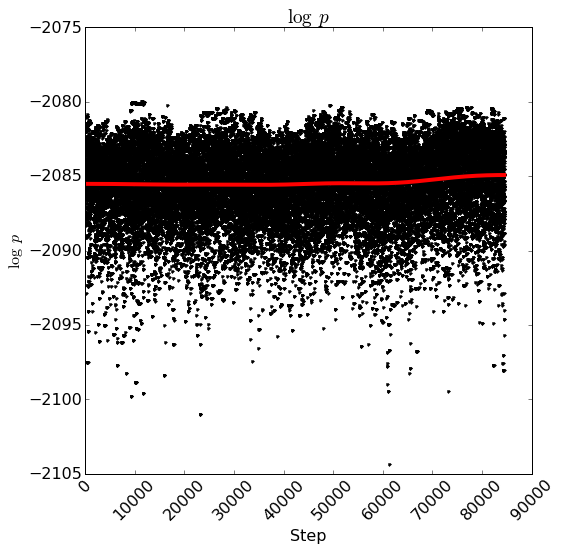

In [31]:
matplotlib.rcParams['font.size'] = 16
fig, ax = plt.subplots(figsize=(8,8))
from scipy.ndimage import gaussian_filter1d
ax.set_title('$\log \,p$')
ax.plot(lnp, 'k.')#, alpha=0.08)
ax.plot(gaussian_filter1d(lnp, 0.1*len(lnp)), 'r', lw=4)
ax.set_xlabel('Step')
ax.set_ylabel('$\log \,p$')
[l.set_rotation(45) for l in ax.get_xticklabels()]
#ax.set_ylim([-2750,-2600])
plt.show()

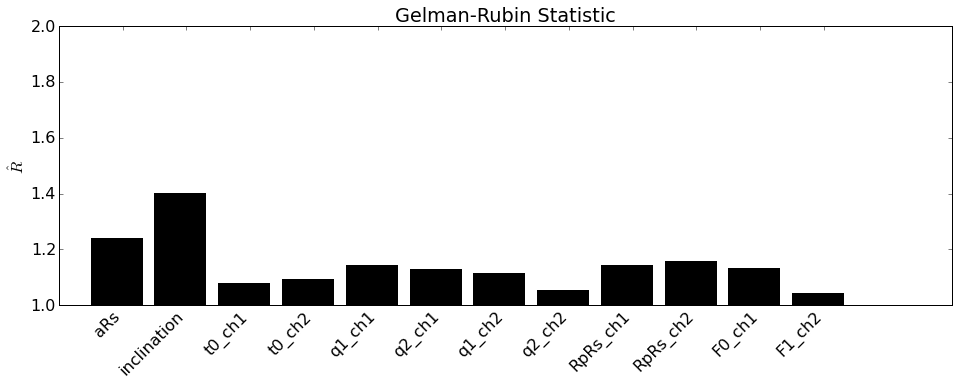

In [32]:
def gelmanrubin(samples, useparameter):
    # W = mean of within-chain variance
    # B = between chain variance
    n, m = np.shape(samples)
    individualchains = [samples[i:, useparameter][::2*m] for i in range(2*m)]
    W = np.mean([np.var(chain, ddof=1) for chain in individualchains])
    B = n*np.var([np.mean(chain) for chain in individualchains], ddof=1)

    Vhat = W*(n-1)/n + B/n
    Rhat = np.sqrt(Vhat/W)
    return Rhat

fig, ax = plt.subplots(1, figsize=(16,5))
for i in range(len(labels)):
    ax.bar(i-0.5, gelmanrubin(samples, i), color='k')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, ha='right')
[l.set_rotation(45) for l in ax.get_xticklabels()]
ax.set_ylim([1,2])
ax.set_xlim([-1, len(labels)+1])
ax.set_ylabel('$\hat{R}$')
ax.set_title('Gelman-Rubin Statistic')
plt.show()